## **Библиотеки и импорт всего что надо**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fashion-product-images-small


In [ ]:
pip install faiss-cpu >> None

In [ ]:
import pandas as pd
import os
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import faiss
from torchvision import models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [ ]:
os.listdir(path)

['myntradataset', 'images', 'styles.csv']

In [ ]:
# === Настройки ===
IMAGE_DIR = os.path.join(path, 'images')  # Путь к изображениям из переменной path
CSV_PATH = os.path.join(path, 'styles.csv')  # Путь к CSV-файлу из переменной path
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# === Загрузка данных ===
def load_data():
    df = pd.read_csv(CSV_PATH, on_bad_lines='skip')
    df['image_path'] = df['id'].astype(str).apply(lambda x: os.path.join(IMAGE_DIR, x + '.jpg'))
    df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)
    return df

df = load_data()

# === Модель ResNet ===
def load_model():
    model = models.resnet50(pretrained=True)
    model = torch.nn.Sequential(*list(model.children())[:-1])
    model.eval().to(DEVICE)
    return model

model = load_model()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 225MB/s]


In [ ]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,/kaggle/input/fashion-product-images-small/ima...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,/kaggle/input/fashion-product-images-small/ima...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,/kaggle/input/fashion-product-images-small/ima...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,/kaggle/input/fashion-product-images-small/ima...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,/kaggle/input/fashion-product-images-small/ima...


In [ ]:
df.columns

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName',
       'image_path'],
      dtype='object')

##**EDA анализ**

In [ ]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
palette = sns.color_palette("cubehelix")

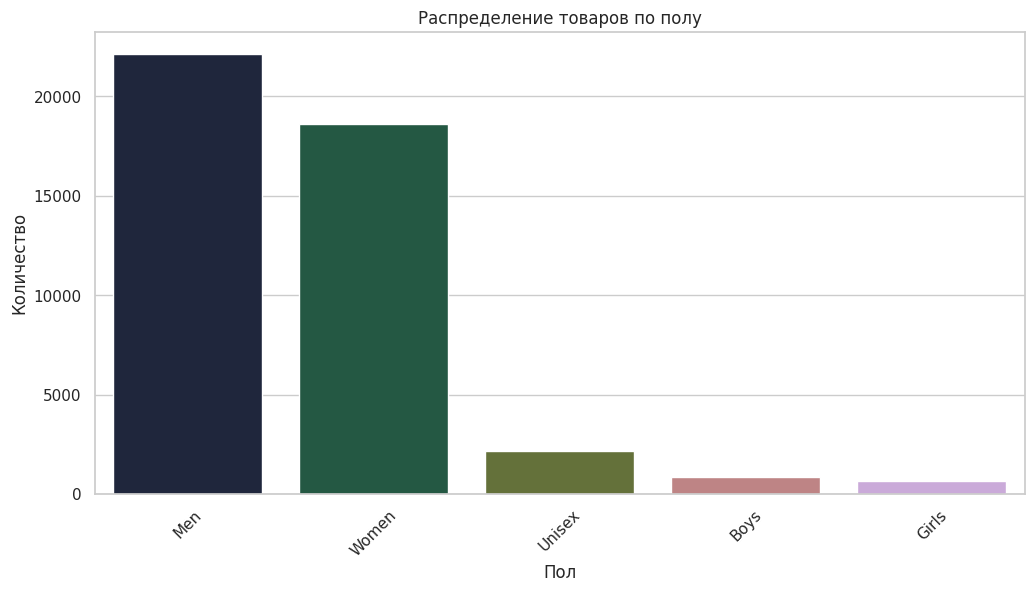

In [ ]:
sns.countplot(data=df, x='gender', order=df['gender'].value_counts().index, palette=palette, hue=None)
plt.title("Распределение товаров по полу")
plt.xlabel("Пол")
plt.ylabel("Количество")
plt.xticks(rotation=45)
plt.show()

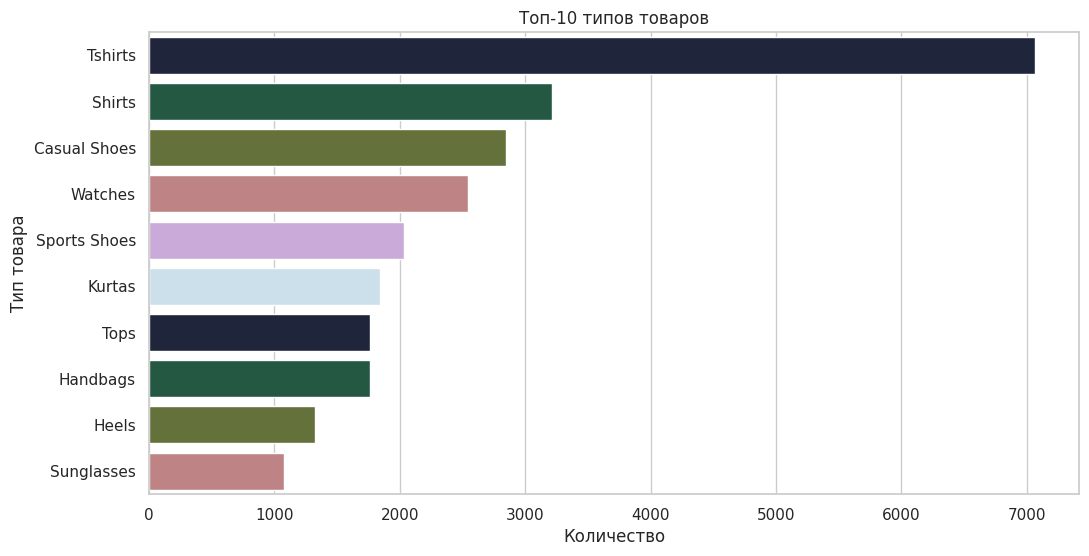

In [ ]:
top_articles = df['articleType'].value_counts().head(10)
sns.barplot(x=top_articles.values, y=top_articles.index, palette=palette)
plt.title("Топ-10 типов товаров")
plt.xlabel("Количество")
plt.ylabel("Тип товара")
plt.show()

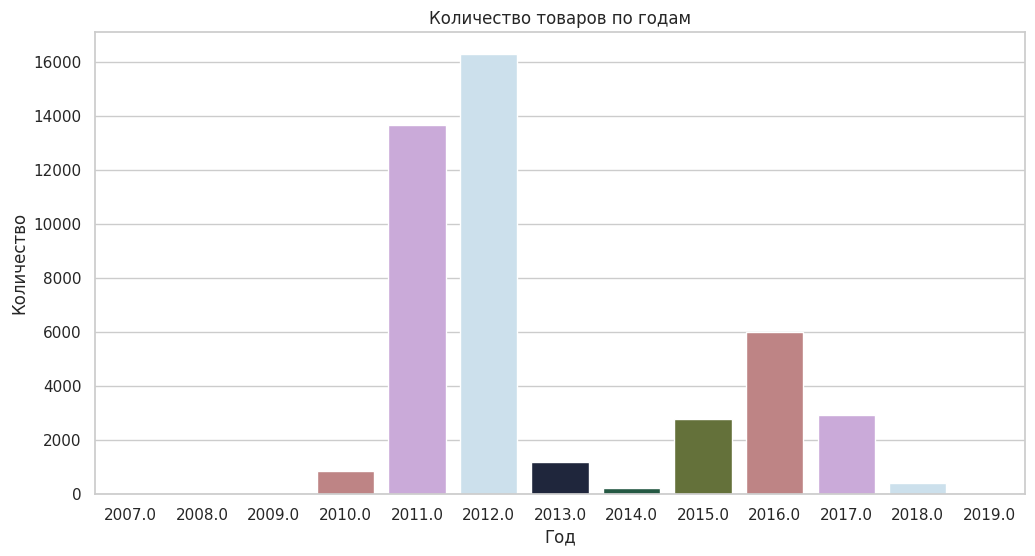

In [ ]:
sns.countplot(data=df, x='year', palette=palette, hue=None)
plt.title("Количество товаров по годам")
plt.xlabel("Год")
plt.ylabel("Количество")
plt.show()

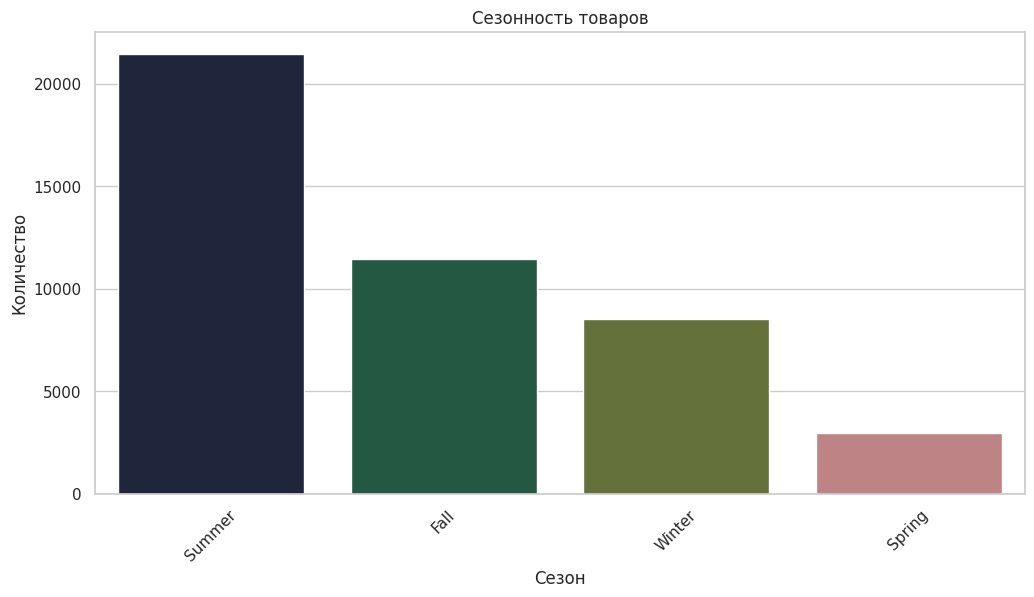

In [ ]:
sns.countplot(data=df, x='season', order=df['season'].value_counts().index, palette=palette, hue=None)
plt.title("Сезонность товаров")
plt.xlabel("Сезон")
plt.ylabel("Количество")
plt.xticks(rotation=45)
plt.show()

## **Подбор моделей и методов**

### **Resnet50**

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def extract_features(df_subset, max_images=400):
    features = []
    paths = []
    with torch.no_grad():
        # Ограничиваем количество изображений до max_images
        for path in tqdm(df_subset['image_path'][:max_images], desc="Извлечение признаков", unit="изображение"):
            try:
                img = Image.open(path).convert('RGB')
                x = transform(img).unsqueeze(0).to(DEVICE)
                feat = model(x).squeeze().cpu().numpy().astype('float32')
                features.append(feat)
                paths.append(path)
            except Exception as e:
                print(f"Ошибка при обработке {path}: {e}")
                continue
    return np.stack(features), paths

In [ ]:
features, paths = extract_features(df, max_images=5000)

Извлечение признаков: 100%|██████████| 5000/5000 [01:25<00:00, 58.80изображение/s]


In [ ]:
import pickle

In [ ]:
np.save('features.npy', features)

# Сохраняем пути в файл .pkl
with open('paths.pkl', 'wb') as f:
    pickle.dump(paths, f)

print("Данные успешно сохранены!")

Данные успешно сохранены!


In [ ]:
df.to_csv('filtered_products.csv', index=False)

Оценка методов для товара: /kaggle/input/fashion-product-images-small/images/3701.jpg
Рекомендации по методу: Cosine Similarity
  /kaggle/input/fashion-product-images-small/images/52481.jpg


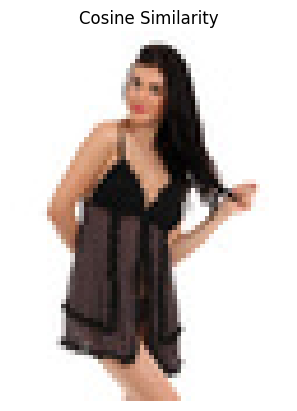

  /kaggle/input/fashion-product-images-small/images/33213.jpg


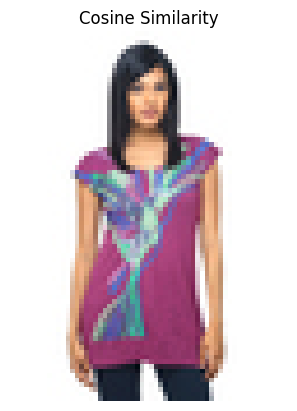

  /kaggle/input/fashion-product-images-small/images/3534.jpg


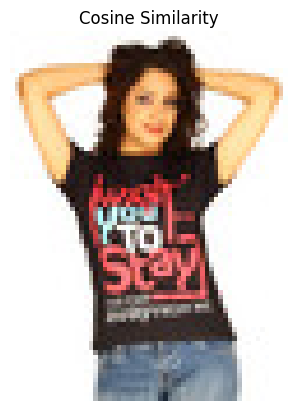

  /kaggle/input/fashion-product-images-small/images/2244.jpg


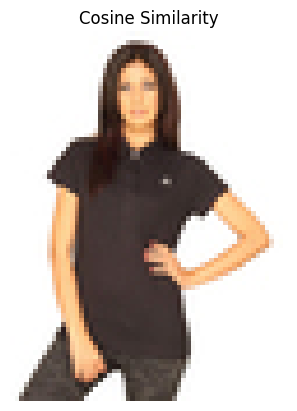

  /kaggle/input/fashion-product-images-small/images/3701.jpg


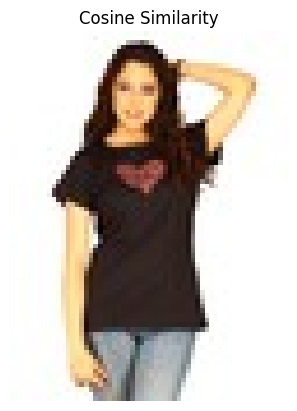

Рекомендации по методу: FAISS
  /kaggle/input/fashion-product-images-small/images/3701.jpg


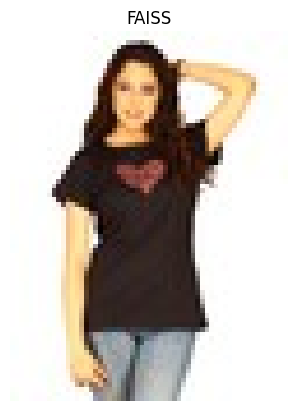

  /kaggle/input/fashion-product-images-small/images/2244.jpg


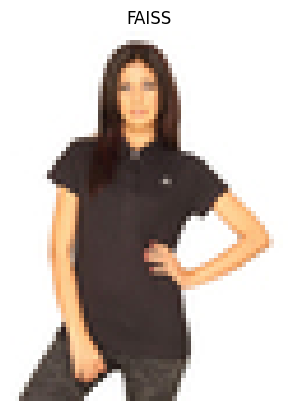

  /kaggle/input/fashion-product-images-small/images/3534.jpg


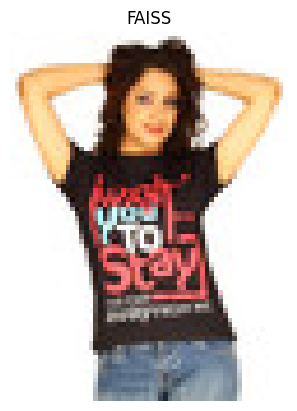

  /kaggle/input/fashion-product-images-small/images/33213.jpg


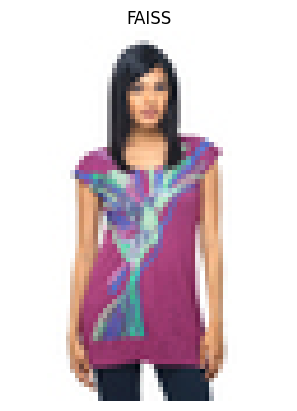

  /kaggle/input/fashion-product-images-small/images/52481.jpg


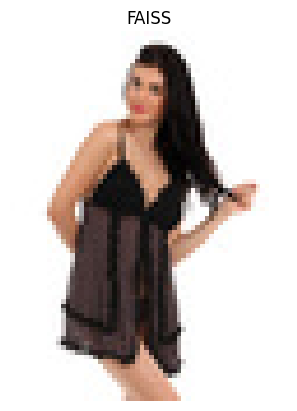

Рекомендации по методу: KMeans
  /kaggle/input/fashion-product-images-small/images/26960.jpg


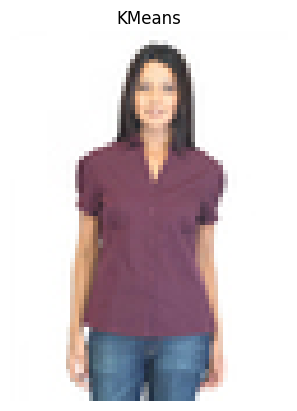

  /kaggle/input/fashion-product-images-small/images/12369.jpg


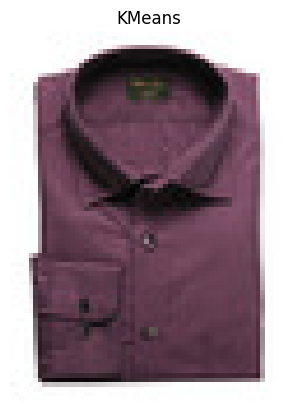

  /kaggle/input/fashion-product-images-small/images/51832.jpg


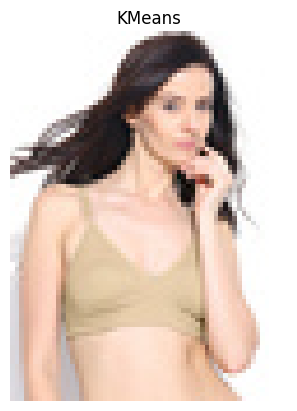

  /kaggle/input/fashion-product-images-small/images/20099.jpg


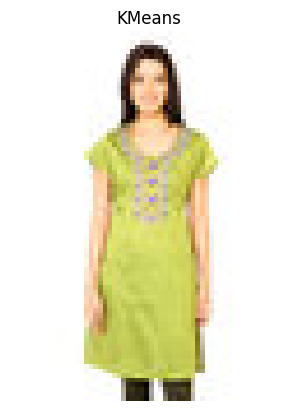

  /kaggle/input/fashion-product-images-small/images/3954.jpg


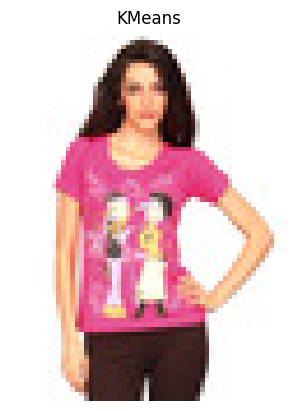

In [ ]:
# === Метод 1: Cosine Similarity ===
def recommend_cosine(query_idx, features, top_k=5):
    query_feat = features[query_idx].reshape(1, -1)
    cosine_sim = cosine_similarity(query_feat, features)
    indices = cosine_sim.argsort()[0][-top_k:]
    return indices

# === Метод 2: FAISS ===
def recommend_faiss(query_idx, features, top_k=5):
    index = faiss.IndexFlatL2(features.shape[1])
    index.add(features)
    D, I = index.search(features[query_idx].reshape(1, -1), top_k)
    return I[0]

# === Метод 3: KMeans ===
def recommend_kmeans(query_idx, features, top_k=5, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(features)
    cluster = kmeans.predict(features[query_idx].reshape(1, -1))
    cluster_idx = np.where(kmeans.labels_ == cluster)[0]
    return cluster_idx[:top_k]

def show_image(image_path, title=None):
    img = Image.open(image_path)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')  # Отключаем оси для лучшего вида
    plt.show()

# === Визуализация ===
def show_recommendations(indices, paths, method_name):
    print(f"Рекомендации по методу: {method_name}")
    for i in indices:
        print(f"  {paths[i]}")
        # Выводим изображение для каждой рекомендации
        show_image(paths[i], title=method_name)

# === Оценка методов ===
def evaluate_methods(query_idx):
    print(f"Оценка методов для товара: {paths[query_idx]}")

    # Cosine Similarity
    cosine_indices = recommend_cosine(query_idx, features)
    show_recommendations(cosine_indices, paths, "Cosine Similarity")

    # FAISS
    faiss_indices = recommend_faiss(query_idx, features)
    show_recommendations(faiss_indices, paths, "FAISS")

    # KMeans
    kmeans_indices = recommend_kmeans(query_idx, features)
    show_recommendations(kmeans_indices, paths, "KMeans")

# === Выбор запроса ===
query_idx = 222  # Задай свой индекс товара


evaluate_methods(query_idx)

In [ ]:
features.shape

(400, 2048)

In [ ]:
paths[5]

'/kaggle/input/fashion-product-images-small/images/1855.jpg'

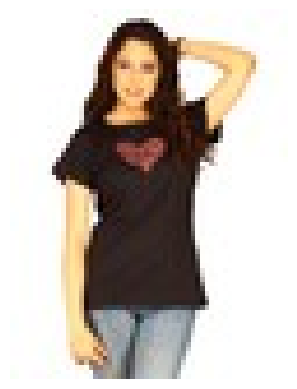

In [ ]:
show_image('/kaggle/input/fashion-product-images-small/images/3701.jpg')

### **EfficientNet-B0**

In [ ]:
efficientnet = models.efficientnet_b0(pretrained=True)
# Удаляем классификатор
model = nn.Sequential(
    efficientnet.features,
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten()
)
model.eval().to(DEVICE)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
features, paths = extract_features(df, max_images=1000)

Извлечение признаков: 100%|██████████| 1000/1000 [00:13<00:00, 75.19изображение/s]


Оценка методов для товара: /kaggle/input/fashion-product-images-small/images/3701.jpg
Рекомендации по методу: Cosine Similarity
  /kaggle/input/fashion-product-images-small/images/7194.jpg


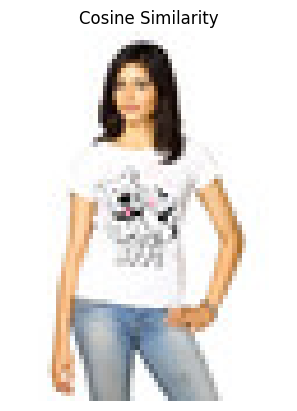

  /kaggle/input/fashion-product-images-small/images/26960.jpg


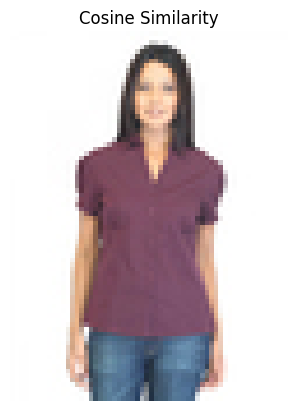

  /kaggle/input/fashion-product-images-small/images/19578.jpg


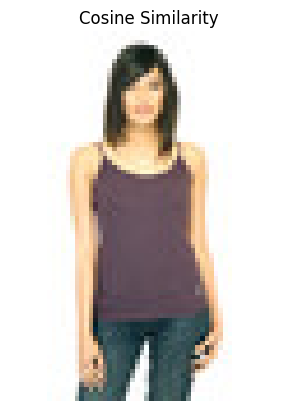

  /kaggle/input/fashion-product-images-small/images/2244.jpg


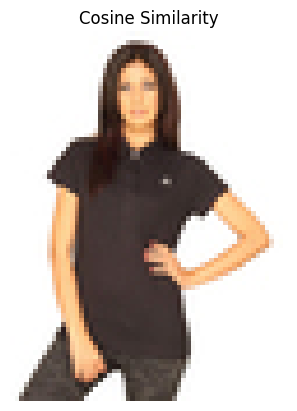

  /kaggle/input/fashion-product-images-small/images/3701.jpg


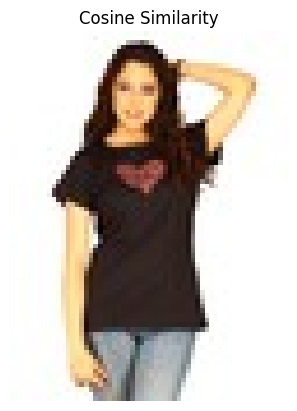

Рекомендации по методу: FAISS
  /kaggle/input/fashion-product-images-small/images/3701.jpg


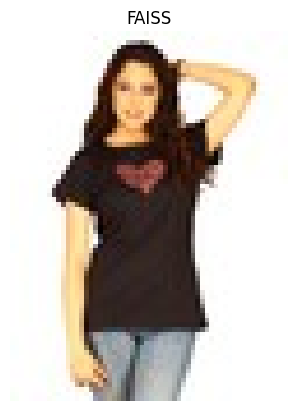

  /kaggle/input/fashion-product-images-small/images/2244.jpg


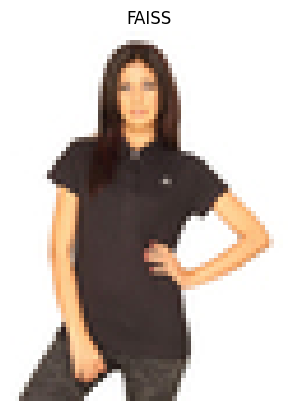

  /kaggle/input/fashion-product-images-small/images/19578.jpg


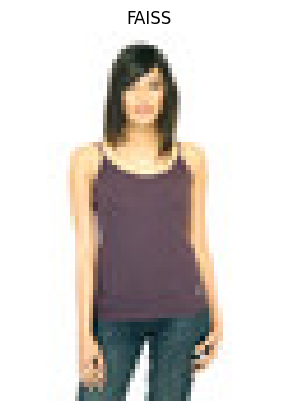

  /kaggle/input/fashion-product-images-small/images/26960.jpg


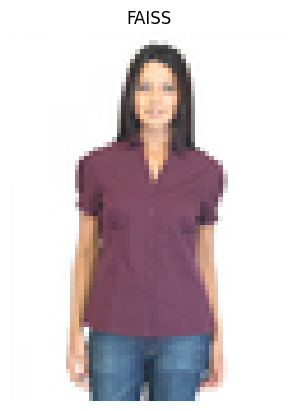

  /kaggle/input/fashion-product-images-small/images/52481.jpg


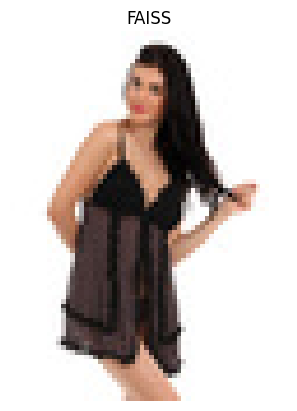

Рекомендации по методу: KMeans
  /kaggle/input/fashion-product-images-small/images/26960.jpg


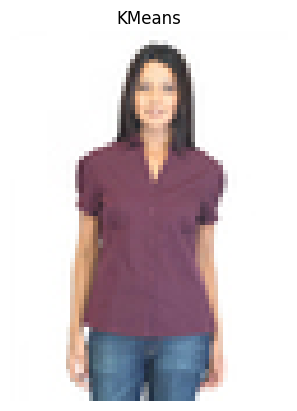

  /kaggle/input/fashion-product-images-small/images/12369.jpg


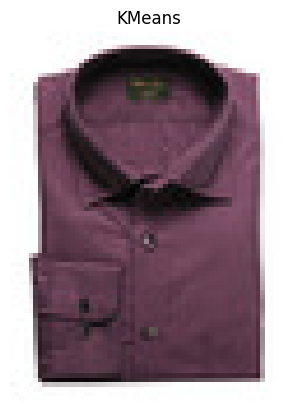

  /kaggle/input/fashion-product-images-small/images/51832.jpg


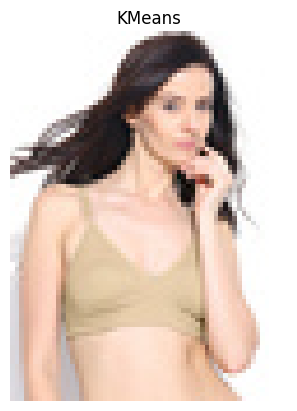

  /kaggle/input/fashion-product-images-small/images/20099.jpg


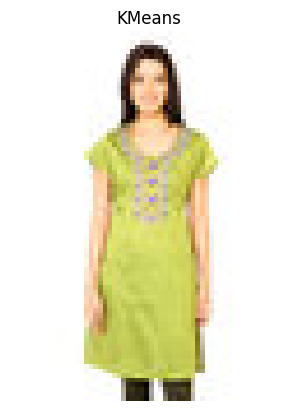

  /kaggle/input/fashion-product-images-small/images/3954.jpg


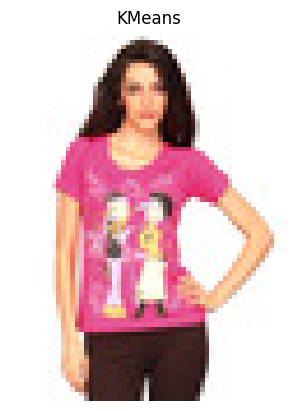

In [ ]:
query_idx = 222  # Задай свой индекс товара
evaluate_methods(query_idx)

### **DenseNet121**

In [ ]:
densenet = models.densenet121(pretrained=True)
# Берём только feature extractor
model = nn.Sequential(
    densenet.features,
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten()
)
model.eval().to(DEVICE)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 69.6MB/s]


Извлечение признаков: 100%|██████████| 1000/1000 [00:20<00:00, 47.86изображение/s]

Оценка методов для товара: /kaggle/input/fashion-product-images-small/images/3701.jpg
Рекомендации по методу: Cosine Similarity
  /kaggle/input/fashion-product-images-small/images/19578.jpg


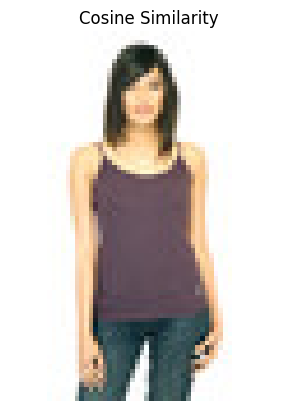

  /kaggle/input/fashion-product-images-small/images/26369.jpg


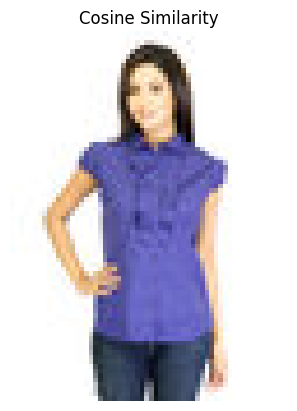

  /kaggle/input/fashion-product-images-small/images/42241.jpg


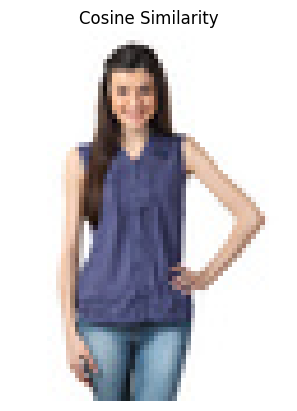

  /kaggle/input/fashion-product-images-small/images/2244.jpg


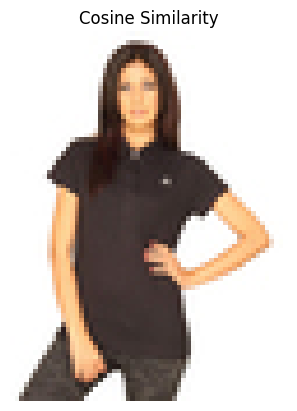

  /kaggle/input/fashion-product-images-small/images/3701.jpg


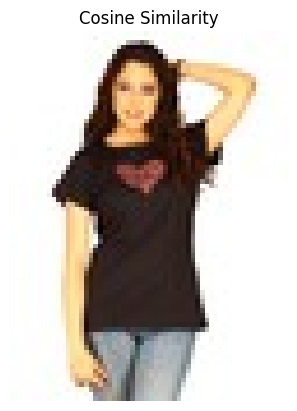

Рекомендации по методу: FAISS
  /kaggle/input/fashion-product-images-small/images/3701.jpg


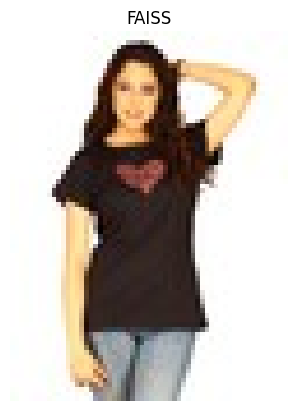

  /kaggle/input/fashion-product-images-small/images/42241.jpg


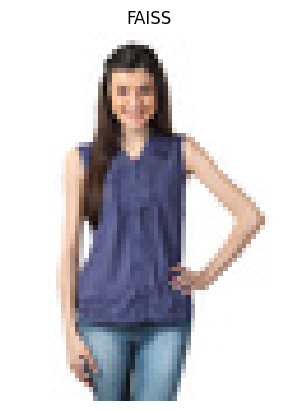

  /kaggle/input/fashion-product-images-small/images/2244.jpg


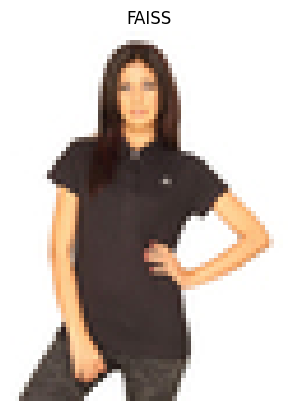

  /kaggle/input/fashion-product-images-small/images/57100.jpg


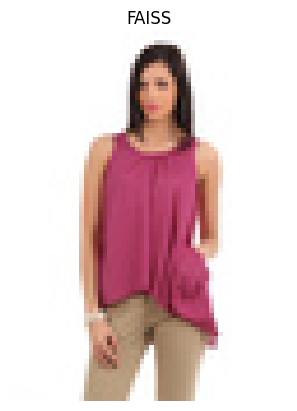

  /kaggle/input/fashion-product-images-small/images/19578.jpg


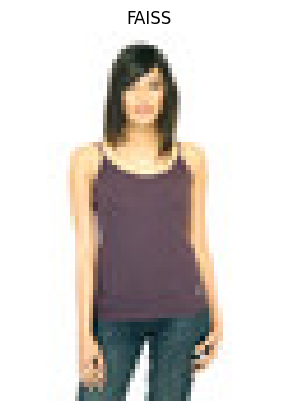

Рекомендации по методу: KMeans
  /kaggle/input/fashion-product-images-small/images/39386.jpg


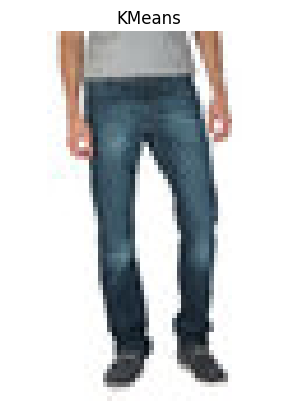

  /kaggle/input/fashion-product-images-small/images/21379.jpg


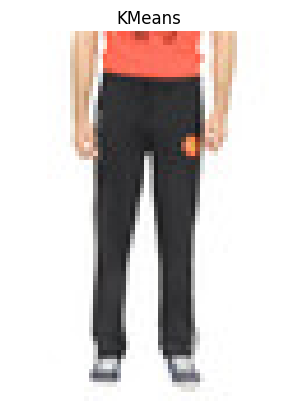

  /kaggle/input/fashion-product-images-small/images/26960.jpg


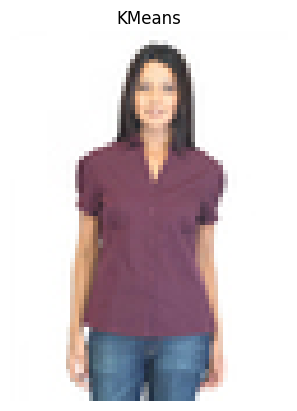

  /kaggle/input/fashion-product-images-small/images/12369.jpg


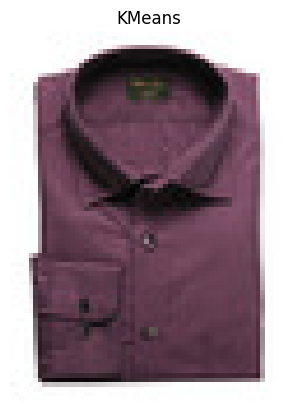

  /kaggle/input/fashion-product-images-small/images/51832.jpg


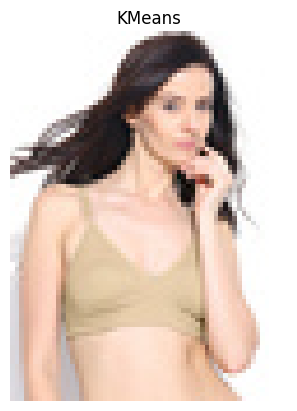

In [ ]:
features, paths = extract_features(df, max_images=1000)
query_idx = 222  # Задай свой индекс товара
evaluate_methods(query_idx)